# Clustering of proteomic data according to their UNIPROT keywords

- Enter the list of proteins in the file "liste_proteines.txt"
- Enter the number of clusters below (nb_cluster)
- Enter the number of most important keywords for each class (top)

In [1]:
nb_cluster=5
top=10

## Library

In [2]:
%pip install kmodes
%pip install bioservices # new
import pandas as pd
import requests, sys, json
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from kmodes.kmodes import KModes

## NEW -> Uniprot library
from bioservices.uniprot import UniProt
u = UniProt(verbose = False)

from google.colab import files
from google.colab import drive
drive.mount('/content/gdrive')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 200 kB 6.7 MB/s 
     |████████████████████████████████| 47 kB 3.1 MB/s 
     |████████████████████████████████| 47 kB 4.4 MB/s 
     |████████████████████████████████| 144 kB 14.3 MB/s 
     |████████████████████████████████| 5.8 MB 33.9 MB/s 
     |████████████████████████████████| 251 kB 37.8 MB/s 
     |████████████████████████████████| 127 kB 11.5 MB/s 
  Created wheel for bioservices: filename=bioservices-1.10.0-py3-none-any.whl size=230646 sha256=ec630b6afe6c03512d1283e61d8d0c861a84acbd024f9d159179901dea37c1cf
  Stored in directory: /root/.cache/pip/wheels/52/b0/10/3f9d68c60400657f9032ec676f093fc8de0af84b71dba29cb8
  Created wheel for easydev: filename=easydev-0.12.0-py3-none-any.whl size=64232 sha256=48f72bf9fddb98bad0a00ead1f01b7ebdccbabef10b3

## Calling functions

In [3]:
# Convert Accession id to Genename

def convert_ACC_GENENAME(id) :
    convert = u.mapping(fr="UniProtKB_AC-ID", to="Gene_Name", query=id)
    return convert['results'][0]['to']

"""
def convert_ACC_GENENAME(id):
    url = 'http://www.uniprot.org/mapping/' 
    params = {'from':'ACC','to':'GENENAME','format':'tab','query':id} 
    request = requests.get(url, params)
    return request.text.split("\n")[1].split("\t")[1]
"""


'\ndef convert_ACC_GENENAME(id):\n    url = \'http://www.uniprot.org/mapping/\' \n    params = {\'from\':\'ACC\',\'to\':\'GENENAME\',\'format\':\'tab\',\'query\':id} \n    request = requests.get(url, params)\n    return request.text.split("\n")[1].split("\t")[1]\n'

In [4]:
# Create a list of proteins
list_acc=[]
with open("/content/gdrive/MyDrive/clustering_proteo/liste_proteines.txt","r") as f:
    for l in f.readlines():
        list_acc.append(l[:-1])
len(list_acc)

150

In [5]:
# Create a dict with protein for keys and keywords for values
dico_kw={}
for i in list_acc:
    URL_api="https://www.ebi.ac.uk/proteins/api/proteins"
    query=f"/{i}"
    URL=URL_api + query
    header = {'Accept': 'application/json'}
    result=requests.get(URL,headers=header)
    data1=result.json()
    list_temp=[]
    try:
        for k in data1["keywords"]:
            list_temp.append(k["value"])
        dico_kw[i]=(list_temp)
    except:
        print(i)
len(dico_kw.keys())

Q9Y2J3
O95426
Q26875
O15076
P49737
Q5ZPR4
Q8N574
Q96EQ1
Q13189
P09197
Q8WUJ4
Q9NQA4
Q16364
Q8NF92
P08755
Q2TAL9
O95529
Q8IZV6
O15077
Q7Z3D8
P49738
Q8TBB8
Q8N575
Q96EQ2
P1210


117

In [6]:
# List of keywords
list_k=[]
for v in dico_kw.values():
    for v1 in v:
        if v1 not in list_k:
            list_k.append(v1)
len(list_k)

244

In [7]:
# Create one vector for each protein with 1 if the keyword is present and 0 if not (multihot encoding)

list_prot=list(dico_kw.keys())
array=np.zeros((len(list_prot),len(list_k)))
for i in range(len(list_prot)):
    for j in range(len(list_k)): 
        if list_k[j] in dico_kw[list_prot[i]]:
            array[i][j]=1
        else:
            array[i][j]=0
            

In [8]:
df = pd.DataFrame(array, index=list_prot,columns=list_k)
#df.head()
#df.shape

In [9]:
# Clustering with kmean
kmeans = KMeans(n_clusters=nb_cluster, random_state=0).fit(df)

In [10]:
# PCA  to display the clusters on a graph
pca = PCA(n_components=2)
data=pca.fit_transform(df)

In [11]:
# Create a column with cluster label (0,1,2...)
df_kw=df
df_kw["cluster"]=kmeans.labels_

In [12]:
# Write a file with the most important keywords and the proteins  for each cluster
colormap=np.array(['Red','green','blue','orange','black','purple'])
kw=pd.read_csv("/content/gdrive/MyDrive/clustering_proteo/keywords-all.tab",sep='\t')
res=kmeans.__dict__
with open("cluster_proteine.txt","w") as f:
  for k in range(nb_cluster):
    f.write("\n\n")
    f.write("*"*50)
    f.write(f"\nClasse: {k} ({colormap[k]})\n")
    f.write("\nListe des keywords:")
    list_kw_weight=[]
    for i in np.argsort(res['cluster_centers_'][k]*-1):
      if list_k[i] not in list(kw.loc[kw["Category"]=="Technical term"]["Name"]):
        if list_k[i] not in list(kw.loc[kw["Category"]=="Coding sequence diversity"]["Name"]):
          list_kw_weight.append(list_k[i])
    for w in list_kw_weight[:top]:
        f.write(f"\n{w}")
    f.write(f"\n\nListe des protéines de la classe {k}:\n")
    for p in df_kw.index[df_kw["cluster"]==k].tolist():
      f.write(f"{p} ")
  files.download("cluster_proteine.txt")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Results

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

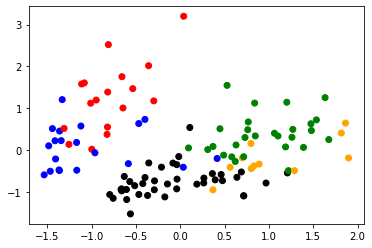

In [13]:
# Display the clusters
plt.scatter(data[:,0],data[:,1],c=colormap[kmeans.labels_])
plt.savefig("ACP_kw.png", format="PNG")
files.download("ACP_kw.png")